In [4]:
import pandas as pd
import numpy as np

# import spacy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import tensorflow as tf
from keras.layers import Dense, Input
from keras.models import Model


In [5]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Twitter Sentiment Analysis/Twitter_Data.csv')

In [6]:
df.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [7]:
df.isnull().sum()

clean_text    4
category      7
dtype: int64

In [8]:
df = df.dropna()

In [9]:
df.isnull().sum()

clean_text    0
category      0
dtype: int64

In [10]:
df.columns = ['text', 'target']
df.loc[:, 'target'] = df.loc[:, 'target'].apply(lambda x: int(x + 1))

In [11]:
df.head()

,text,target
0,when modi promised “minimum government maximum...,0
1,talk all the nonsense and continue all the dra...,1
2,what did just say vote for modi welcome bjp t...,2
3,asking his supporters prefix chowkidar their n...,2
4,answer who among these the most powerful world...,2


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162969 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    162969 non-null  object
 1   target  162969 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.7+ MB


In [13]:
df.text.values[0]

'when modi promised “minimum government maximum governance” expected him begin the difficult job reforming the state why does take years get justice state should and not business and should exit psus and temples'

In [14]:
df.loc[:, 'text'] = df.loc[:, 'text'].str.strip()

In [15]:
df.head()

,text,target
0,when modi promised “minimum government maximum...,0
1,talk all the nonsense and continue all the dra...,1
2,what did just say vote for modi welcome bjp t...,2
3,asking his supporters prefix chowkidar their n...,2
4,answer who among these the most powerful world...,2


In [16]:
lengths = [len(each) for each in df['text'].values]

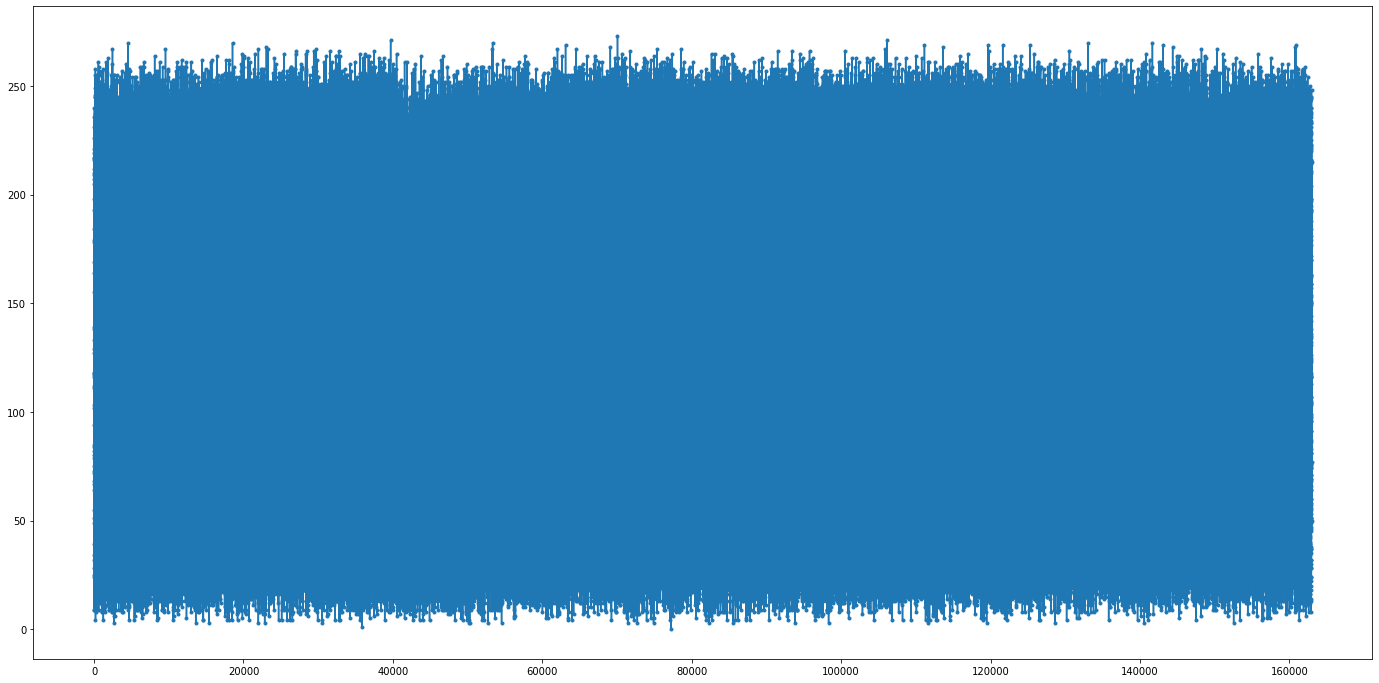

In [17]:
plt.figure(figsize=(24, 12))
plt.plot(lengths, marker='.')

In [18]:
length_over_100 = len([each for each in lengths if each > 100])
length_over_150 = len([each for each in lengths if each > 150])
length_over_200 = len([each for each in lengths if each > 200])
length_over_250 = len([each for each in lengths if each > 250])
length_over_260 = len([each for each in lengths if each > 260])
length_over_265 = len([each for each in lengths if each > 265])

print(length_over_100)
print(length_over_150)
print(length_over_200)
print(length_over_250)
print(length_over_260)
print(length_over_265)

91020
58191
31093
1821
201
46


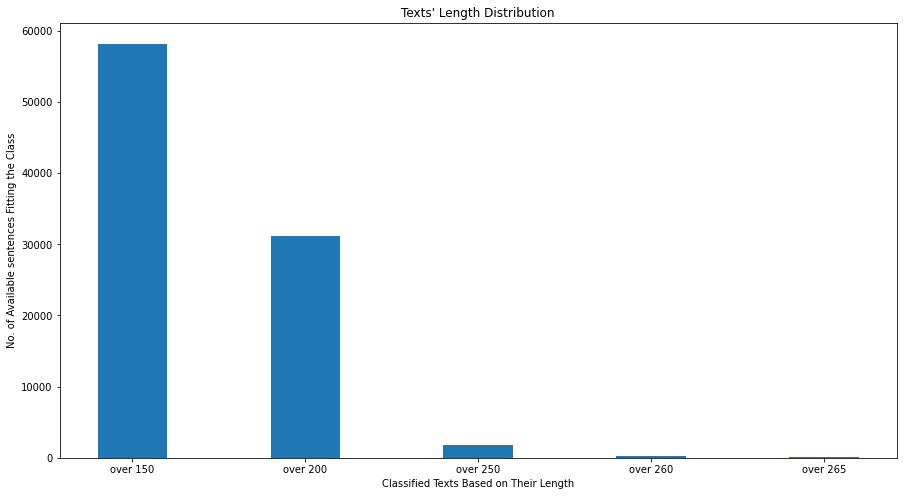

In [19]:
data = {'over 150': length_over_150,
        'over 200': length_over_200,
        'over 250': length_over_250,
        'over 260': length_over_260,
        'over 265': length_over_265}

classes = list(data.keys())
values = list(data.values())

fig = plt.figure(figsize = (15, 8))

plt.bar(classes, values, width = 0.4)

plt.xlabel("Classified Texts Based on Their Length")
plt.ylabel("No. of Available sentences Fitting the Class")
plt.title("Texts' Length Distribution")
plt.show()

In [20]:
SEQ_LEN = 250
num_samples = len(df)
batch_size = 16

In [21]:
Xids = np.zeros((num_samples, SEQ_LEN))
Xmask = np.zeros((num_samples, SEQ_LEN))

In [22]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 34.7 MB/s 
     |████████████████████████████████| 101 kB 13.5 MB/s 
     |████████████████████████████████| 6.6 MB 52.4 MB/s 
     |████████████████████████████████| 596 kB 59.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [23]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

for i, text in enumerate(df.text):
    tokens = tokenizer.encode_plus(text, truncation=True, max_length=SEQ_LEN,
                                padding='max_length',
                                add_special_tokens=True,
                                return_tensors='tf')
    
    Xids[i, :] = tokens['input_ids']
    Xmask[i, :] = tokens['attention_mask']

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [24]:
targets = df['target'].values
labels = np.zeros((num_samples, targets.max() + 1))
del df

In [25]:
labels[np.arange(num_samples), targets] = 1

In [26]:
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))

dataset.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(250,), dtype=tf.float64, name=None), TensorSpec(shape=(250,), dtype=tf.float64, name=None), TensorSpec(shape=(3,), dtype=tf.float64, name=None))>

In [27]:
def generate_standard_input(input_ids, masks, labels):
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

In [28]:
dataset = dataset.map(generate_standard_input)

In [29]:
dataset = dataset.shuffle(1000).batch(batch_size, drop_remainder=True)

dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 250), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(16, 250), dtype=tf.float64, name=None)}, TensorSpec(shape=(16, 3), dtype=tf.float64, name=None))>

In [30]:
train_split = 0.9

idx = int((num_samples / batch_size) * train_split)

In [31]:
train_ds = dataset.take(idx)
val_ds = dataset.skip(idx)

In [32]:
del dataset

In [33]:
from transformers import TFAutoModel

In [34]:
bert = TFAutoModel.from_pretrained('bert-base-cased')

bert.summary()

Downloading:   0%|          | 0.00/502M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
Total params: 108,310,272
Trainable params: 108,310,272
Non-trainable params: 0
_________________________________________________________________


In [35]:
input_ids = Input(shape=(SEQ_LEN,), name='input_ids', dtype='int32')
mask = Input(shape=(SEQ_LEN,), name='attention_mask', dtype='int32')

embeddings = bert.bert(input_ids, attention_mask=mask)[1]

d1 = Dense(512, activation='relu')(embeddings)
# d2 = Dense(128, activation='relu')(d1)
# d3 = Dense(64, activation='relu')(d2)
# d4 = Dense(64, activation='relu')(d3)
out = Dense(targets.max() + 1, activation='softmax', name='outputs')(d1)

model = Model(inputs=[input_ids, mask], outputs=out)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 250)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 250)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 250,                                           

In [36]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-6)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [37]:
hist = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=1
)

9167/9167 [==============================] - 7607s 829ms/step - loss: 0.2123 - accuracy: 0.9246 - val_loss: 0.0954 - val_accuracy: 0.9696
